# Disease detection from Potato Plant Leaves
During the potato growing process, some diseases can be found on the leaves of the plants. These diseases can be list as
*   Late Blight
*   Early Blight

Detection of diseased plants is of great importance during the growing process of potato plants. In this study, the classification of diseased and healthy potato plants was carried out using the Potato Disease Leaf Dataset (PLD).


# Loading Data

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rizwan123456789/potato-disease-leaf-datasetpld")

print("Path to dataset files:", path)

Path to dataset files: /Users/sudetungac/.cache/kagglehub/datasets/rizwan123456789/potato-disease-leaf-datasetpld/versions/1


In [23]:
import pandas as pd
import os

def create_csv(data_dir, csv_filename):

    rows = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                rows.append({"path": image_path, "class": class_name})
    df = pd.DataFrame(rows)
    df.to_csv(csv_filename, index=False)


base_dir = os.path.join(path, 'PLD_3_Classes_256')

training_dir = os.path.join(base_dir, "Training")
create_csv(training_dir, "../data/training.csv")

testing_dir = os.path.join(base_dir, "Testing")
create_csv(testing_dir, "../data/testing.csv")

validation_dir = os.path.join(base_dir, "Validation")
create_csv(validation_dir, "../data/validation.csv")


# Making Data Ready to Use

In [24]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
# Load the CSV files
train_df = pd.read_csv('../data/training.csv')
val_df = pd.read_csv('../data/validation.csv')
test_df = pd.read_csv('../data/testing.csv')

# Image preprocessing and data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                                path        class
0  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
1  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
2  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
3  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
4  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
                                                path        class
0  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
1  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
2  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
3  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
4  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
                                                path        class
0  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
1  /Users/sudetungac/.cache/kagglehub/datasets/ri...  Late_Blight
2  /Users/

In [6]:
# Create image data generators
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='path',
                                                    y_col='class',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')


val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                x_col='path',
                                                y_col='class',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')


test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                x_col='path',
                                                y_col='class',
                                                target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 3251 validated image filenames belonging to 3 classes.
Found 416 validated image filenames belonging to 3 classes.
Found 405 validated image filenames belonging to 3 classes.


In [ ]:
# Saving class names during training
import json
with open("./class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

# Training and Testing Phases of Models

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
shape = [224,224]
classes = 3
batch_size = 32
epochs = 10

In [11]:
# Getting class names to use during prediction
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

# Sort the keys according to softmax order
class_names = [class_name for class_name, idx in sorted(class_indices.items(), key=lambda item: item[1])]


## Training and Testing Stages with the VGG16 Model

In [ ]:
#CNN with 16 layers - VGG
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

vgg16 = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in vgg16.layers:
  layer.trainable = False

x = Flatten()(vgg16.output)
x = Dense(128, activation = 'relu', kernel_regularizer=l2(0.01))(x)
x = Dense(64, activation = 'relu', kernel_regularizer=l2(0.01))(x)
x = Dense(classes, activation = 'softmax')(x)
vgg = Model(inputs = vgg16.input, outputs = x)

vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# train model block
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs = 10

vgg_history = vgg.fit(train_generator,
          validation_data=val_generator,
          epochs=epochs,
          callbacks=[early_stopping])
print('Training Completed!')


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 78s 641ms/step - accuracy: 0.5129 - loss: 3.0497 - val_accuracy: 0.8005 - val_loss: 1.1418
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - accuracy: 0.7567 - loss: 1.1655 - val_accuracy: 0.8510 - val_loss: 0.8234
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 544ms/step - accuracy: 0.7967 - loss: 0.9047 - val_accuracy: 0.8197 - val_loss: 0.8377
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 51s 502ms/step - accuracy: 0.7731 - loss: 0.9193 - val_accuracy: 0.8510 - val_loss: 0.7260
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 471ms/step - accuracy: 0.8061 - loss: 0.8140 - val_accuracy: 0.8750 - val_loss: 0.6537
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 476ms/step - accuracy: 0.7748 - loss: 0.8390 - val_accuracy: 0.8750 - val_loss: 0.6397
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 547ms/step - accuracy: 0.8048 - loss: 0.7554 - val_accuracy: 0.8630 - val_loss: 0.6401
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - accuracy: 0.8167 - loss: 0

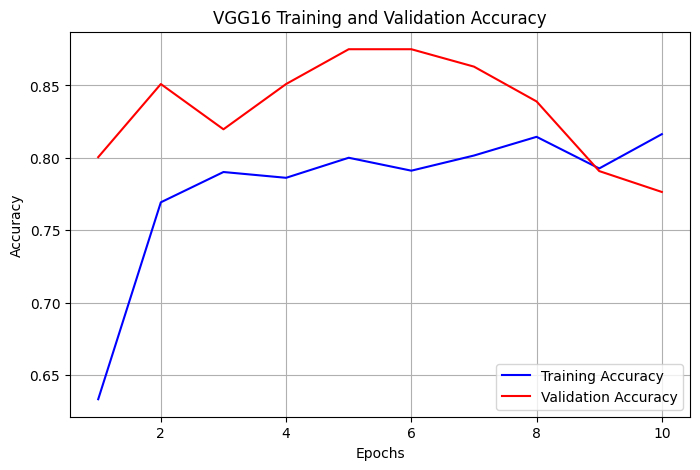

In [ ]:
# After training the model, get the accuracies from the history object
train_accuracy = vgg_history.history['accuracy']
val_accuracy = vgg_history.history['val_accuracy']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_accuracy, 'b-', label='Training Accuracy')  
plt.plot(range(len(train_accuracy)), val_accuracy, 'r-', label='Validation Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


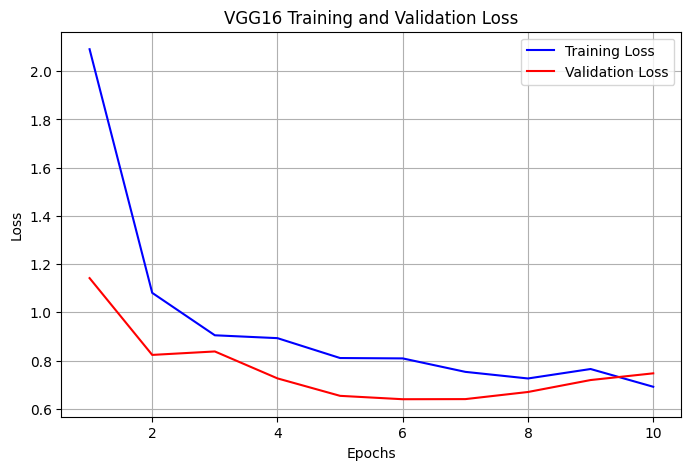

In [ ]:
# After training the model, get the losses from the history object
train_loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_loss, 'b-', label='Training Loss')  
plt.plot(range(len(train_accuracy)), val_loss, 'r-', label='Validation Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# 10 epoch VGG16 test block
Y_pred = vgg.predict(test_generator)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_generator.classes
cm = confusion_matrix(val_trues, val_preds)
report = classification_report(val_trues, val_preds, target_names=class_names)

# Print classification report for reference
print(report)
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 905ms/step
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       162
           1       0.86      0.85      0.86       102
           2       0.77      0.96      0.85       141

    accuracy                           0.86       405
   macro avg       0.87      0.86      0.86       405
weighted avg       0.87      0.86      0.86       405

[[125  11  26]
 [  1  87  14]
 [  3   3 135]]


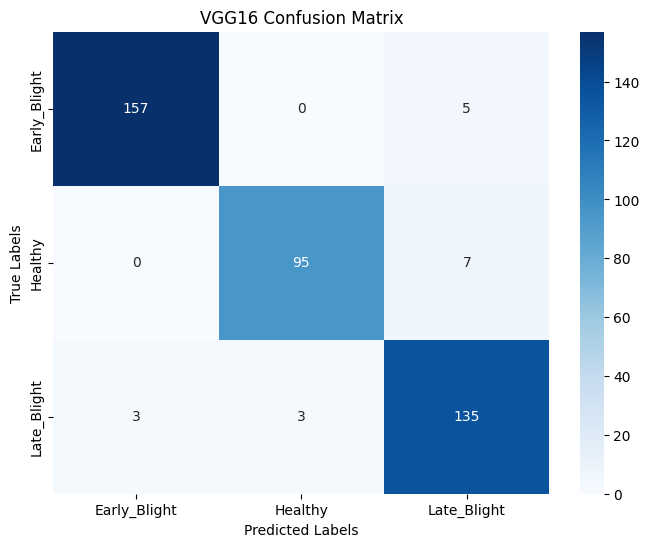

In [ ]:
# Visualize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('VGG16 Confusion Matrix')
plt.show()

## Training and Testing Stages with the LeNet Model

In [ ]:
#Lenet
lenet = models.Sequential()

# Convolutional layers
lenet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
lenet.add(layers.BatchNormalization())
lenet.add(layers.AveragePooling2D((2, 2)))

lenet.add(layers.Conv2D(64, (3, 3), activation='relu'))
lenet.add(layers.BatchNormalization())
lenet.add(layers.AveragePooling2D((2, 2)))

lenet.add(layers.Conv2D(128, (3, 3), activation='relu'))
lenet.add(layers.BatchNormalization())

lenet.add(layers.Flatten())

# Fully connected layers
lenet.add(layers.Dense(128, activation='relu'))
lenet.add(layers.BatchNormalization())
lenet.add(layers.Dropout(0.5))

lenet.add(layers.Dense(64, activation='relu'))
lenet.add(layers.BatchNormalization())
lenet.add(layers.Dropout(0.5))

# Output layer
lenet.add(layers.Dense(classes, activation='softmax'))

lenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# train model block
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs = 10

lenet_history = lenet.fit(train_generator,
          validation_data=val_generator,
          epochs=epochs,
          callbacks=[early_stopping])
print('Training Completed!')


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 474ms/step - accuracy: 0.4869 - loss: 1.3127 - val_accuracy: 0.2452 - val_loss: 3.6263
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 417ms/step - accuracy: 0.5702 - loss: 1.0306 - val_accuracy: 0.2452 - val_loss: 5.1461
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.6356 - loss: 0.8818 - val_accuracy: 0.2452 - val_loss: 5.8560
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 411ms/step - accuracy: 0.6983 - loss: 0.7145 - val_accuracy: 0.2452 - val_loss: 3.1141
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.7303 - loss: 0.6763 - val_accuracy: 0.4615 - val_loss: 1.5819
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.7345 - loss: 0.6461 - val_accuracy: 0.6851 - val_loss: 0.7089
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 411ms/step - accuracy: 0.7836 - loss: 0.5677 - val_accuracy: 0.7091 - val_loss: 0.6872
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - accuracy: 0.7708 - loss: 0

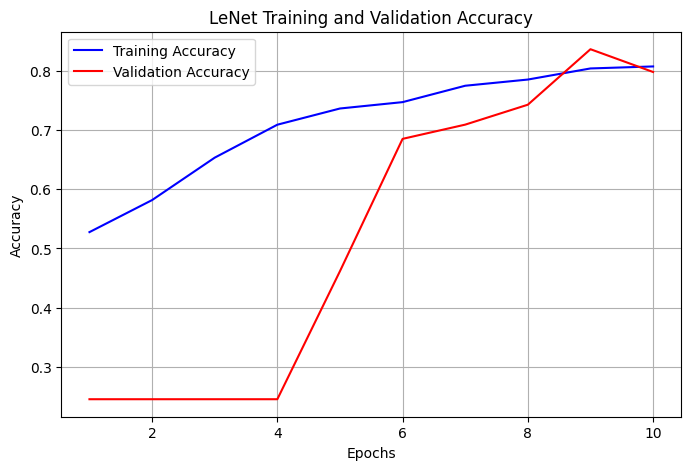

In [ ]:
# After training the model, get the accuracies from the history object
train_accuracy = lenet_history.history['accuracy']
val_accuracy = lenet_history.history['val_accuracy']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_accuracy, 'b-', label='Training Accuracy')  
plt.plot(range(len(train_accuracy)), val_accuracy, 'r-', label='Validation Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LeNet Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


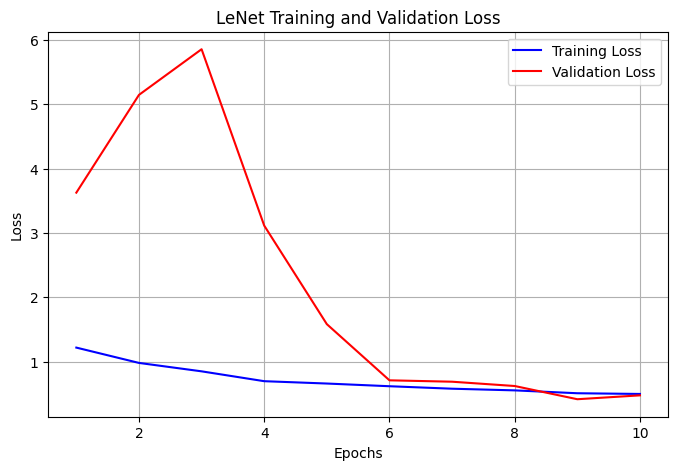

In [ ]:
# After training the model, get the losses from the history object
train_loss = lenet_history.history['loss']
val_loss = lenet_history.history['val_loss']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_loss, 'b-', label='Training Loss')  
plt.plot(range(len(train_accuracy)), val_loss, 'r-', label='Validation Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LeNet Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 10 epoch LeNet test block
Y_pred = lenet.predict(test_generator)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_generator.classes
cm = confusion_matrix(val_trues, val_preds)
report = classification_report(val_trues, val_preds, target_names=class_names)

# Print classification report for reference
print(report)
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
              precision    recall  f1-score   support

Early_Blight       0.84      0.86      0.85       162
     Healthy       0.87      0.71      0.78       102
 Late_Blight       0.79      0.88      0.84       141

    accuracy                           0.83       405
   macro avg       0.84      0.82      0.82       405
weighted avg       0.83      0.83      0.83       405

[[140   5  17]
 [ 15  72  15]
 [ 11   6 124]]


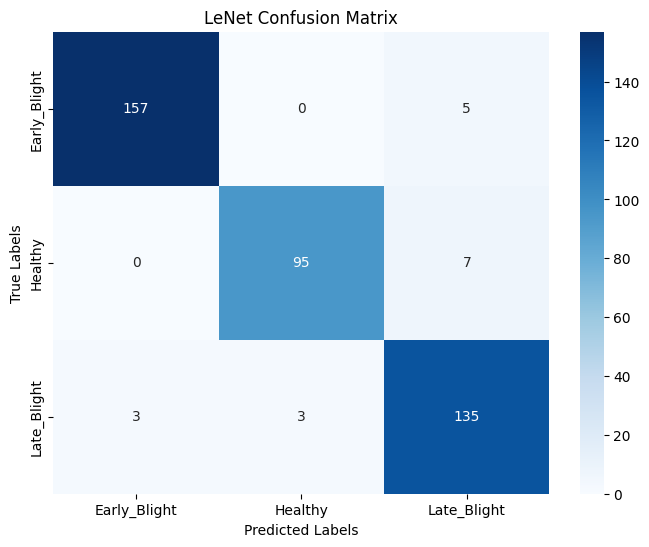

In [ ]:
# Visualize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LeNet Confusion Matrix')
plt.show()

## Training and Testing Stages with the ResNet Model

In [12]:
# ResNet
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet152V2

res = ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg'  # Use global average pooling
)

# Freeze the layers of ResNet
for layer in res.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = res.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Create the final model
resnet = Model(inputs=res.input, outputs=output)

# Compile the model
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2025-05-10 16:07:19.832719: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-10 16:07:19.832782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-10 16:07:19.832787: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-10 16:07:19.832810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-10 16:07:19.832830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# train model block
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs = 10

resnet_history = resnet.fit(train_generator,
          validation_data=val_generator,
          epochs=epochs,
          callbacks=[early_stopping])
print('Training Completed!')


/Users/sudetungac/miniconda3/envs/decease-part2/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-05-10 16:07:35.597595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


102/102 ━━━━━━━━━━━━━━━━━━━━ 56s 452ms/step - accuracy: 0.6659 - loss: 0.9933 - val_accuracy: 0.9062 - val_loss: 0.2651
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.8335 - loss: 0.4431 - val_accuracy: 0.9014 - val_loss: 0.2488
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 382ms/step - accuracy: 0.8475 - loss: 0.3935 - val_accuracy: 0.9471 - val_loss: 0.1833
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - accuracy: 0.8739 - loss: 0.3383 - val_accuracy: 0.9447 - val_loss: 0.1819
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 377ms/step - accuracy: 0.8725 - loss: 0.3267 - val_accuracy: 0.9327 - val_loss: 0.1870
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - accuracy: 0.8914 - loss: 0.3008 - val_accuracy: 0.9471 - val_loss: 0.1728
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - accuracy: 0.8952 - loss: 0.2769 - val_accuracy: 0.9471 - val_loss: 0.1618
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 377ms/step - accuracy: 0.9072 - loss: 0.2638 - val

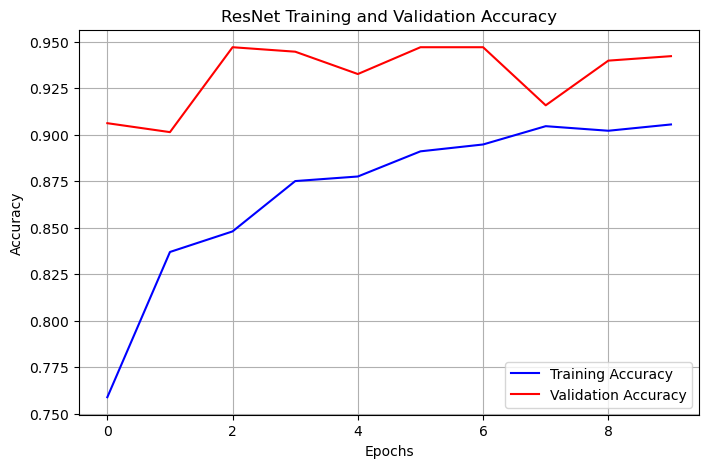

In [16]:
# After training the model, get the accuracies from the history object
train_accuracy = resnet_history.history['accuracy']
val_accuracy = resnet_history.history['val_accuracy']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_accuracy, 'b-', label='Training Accuracy')  
plt.plot(range(len(train_accuracy)), val_accuracy, 'r-', label='Validation Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


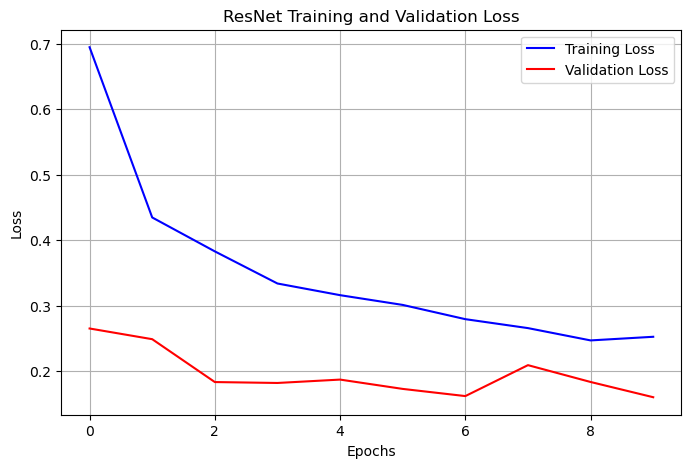

In [18]:
# After training the model, get the losses from the history object
train_loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_loss, 'b-', label='Training Loss')  
plt.plot(range(len(train_accuracy)), val_loss, 'r-', label='Validation Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [19]:
# 10 epoch ResNet test block
Y_pred = resnet.predict(test_generator)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_generator.classes
cm = confusion_matrix(val_trues, val_preds)
report = classification_report(val_trues, val_preds, target_names=class_names)

# Print classification report for reference
print(report)
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 749ms/step
              precision    recall  f1-score   support

Early_Blight       1.00      0.96      0.98       162
     Healthy       0.95      0.98      0.97       102
 Late_Blight       0.95      0.98      0.97       141

    accuracy                           0.97       405
   macro avg       0.97      0.97      0.97       405
weighted avg       0.97      0.97      0.97       405

[[155   2   5]
 [  0 100   2]
 [  0   3 138]]


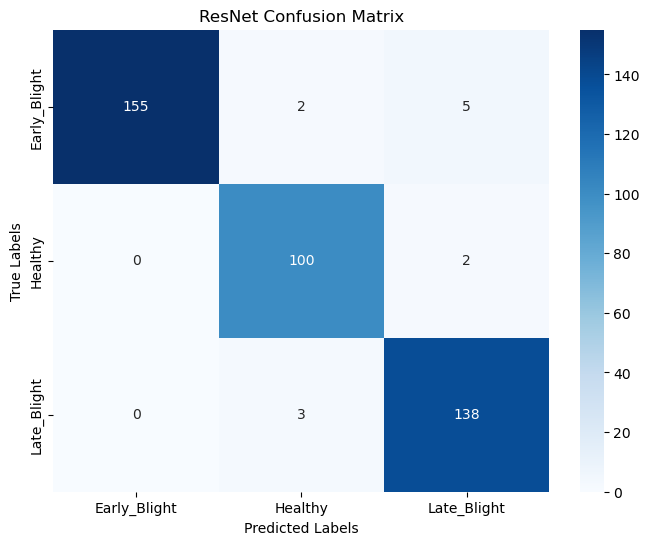

In [20]:
# Visualize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ResNet Confusion Matrix')
plt.show()

## Training and Testing Stages with the GoogleNet Model

In [ ]:
#google net
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze all the layers in the base model
for layer in base_model.layers[100:]:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Increased units for deeper learning
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Reduced dropout rate
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(classes, activation='softmax')(x)

# Create the final model
googlenet = Model(inputs=base_model.input, outputs=x)

# Compile the model
googlenet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# google net training block
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs = 10

googlenet_history = googlenet.fit(train_generator,
          validation_data=val_generator,
          epochs=epochs,
          callbacks=[early_stopping])
print('Training Completed!')

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 116s 727ms/step - accuracy: 0.4932 - loss: 1.2714 - val_accuracy: 0.8462 - val_loss: 0.4485
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 446ms/step - accuracy: 0.7958 - loss: 0.5321 - val_accuracy: 0.9038 - val_loss: 0.2851
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 445ms/step - accuracy: 0.8326 - loss: 0.4477 - val_accuracy: 0.9014 - val_loss: 0.2460
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 448ms/step - accuracy: 0.8659 - loss: 0.3660 - val_accuracy: 0.9111 - val_loss: 0.2142
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 442ms/step - accuracy: 0.8814 - loss: 0.3030 - val_accuracy: 0.9351 - val_loss: 0.1897
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 442ms/step - accuracy: 0.8907 - loss: 0.3122 - val_accuracy: 0.9303 - val_loss: 0.1673
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 445ms/step - accuracy: 0.8919 - loss: 0.2953 - val_accuracy: 0.9351 - val_loss: 0.1525
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - accuracy: 0.9099 - loss: 

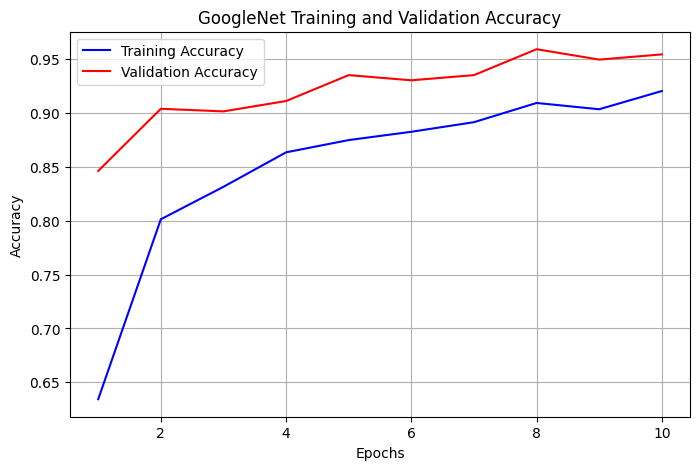

In [ ]:
# After training the model, get the accuracies from the history object
train_accuracy = googlenet_history.history['accuracy']
val_accuracy = googlenet_history.history['val_accuracy']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_accuracy, 'b-', label='Training Accuracy')  
plt.plot(range(len(train_accuracy)), val_accuracy, 'r-', label='Validation Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GoogleNet Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


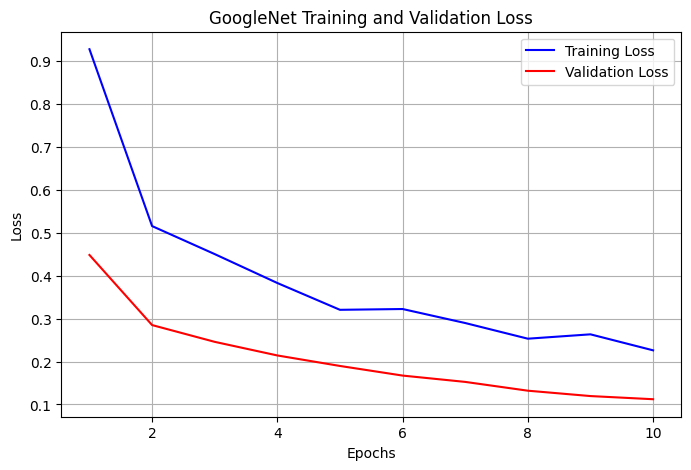

In [ ]:
# After training the model, get the losses from the history object
train_loss = googlenet_history.history['loss']
val_loss = googlenet_history.history['val_loss']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_loss, 'b-', label='Training Loss')  
plt.plot(range(len(train_accuracy)), val_loss, 'r-', label='Validation Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GoogleNet Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 10 epoch GoogleNet test block
Y_pred = googlenet.predict(test_generator)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_generator.classes
cm = confusion_matrix(val_trues, val_preds)
report = classification_report(val_trues, val_preds, target_names=class_names)

# Print classification report for reference
print(report)
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 827ms/step
              precision    recall  f1-score   support

Early_Blight       0.98      0.97      0.97       162
     Healthy       0.92      0.96      0.94       102
 Late_Blight       0.96      0.94      0.95       141

    accuracy                           0.96       405
   macro avg       0.95      0.96      0.95       405
weighted avg       0.96      0.96      0.96       405

[[157   3   2]
 [  0  98   4]
 [  4   5 132]]


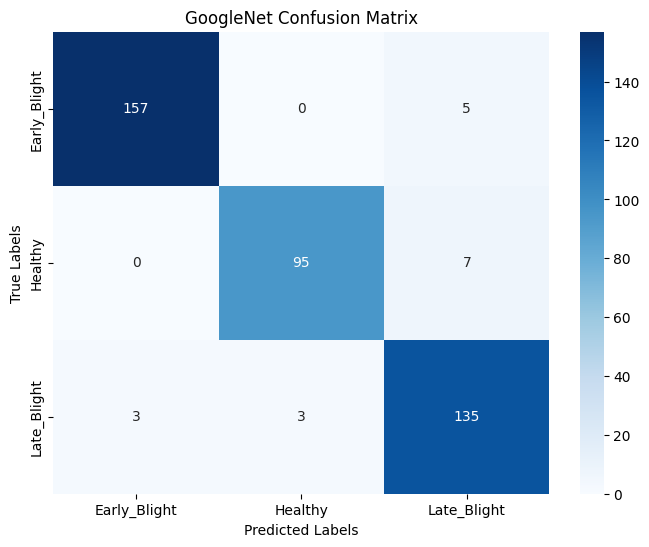

In [ ]:
# Visualize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('GoogleNet Confusion Matrix')
plt.show()

## Training and Testing Stages with the MobileNet Model

In [ ]:
#mobilnet

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(classes, activation='softmax')(x)

# Create the final model
mobilenet = Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# mobilenet training block
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 10
mobilenet_history = mobilenet.fit(train_generator,
          validation_data=test_generator,
          epochs=epochs,
          callbacks=[early_stopping])
print('Training Completed!')

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 63s 506ms/step - accuracy: 0.6172 - loss: 4.2758 - val_accuracy: 0.8123 - val_loss: 3.5925
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 387ms/step - accuracy: 0.8034 - loss: 3.4590 - val_accuracy: 0.9037 - val_loss: 3.0413
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.8355 - loss: 3.1424 - val_accuracy: 0.9235 - val_loss: 2.8226
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 391ms/step - accuracy: 0.8576 - loss: 2.9351 - val_accuracy: 0.9185 - val_loss: 2.6238
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 391ms/step - accuracy: 0.8661 - loss: 2.7249 - val_accuracy: 0.9333 - val_loss: 2.4698
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.8792 - loss: 2.5593 - val_accuracy: 0.8691 - val_loss: 2.5353
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 388ms/step - accuracy: 0.8712 - loss: 2.4183 - val_accuracy: 0.9358 - val_loss: 2.1870
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 389ms/step - accuracy: 0.8845 - loss: 2

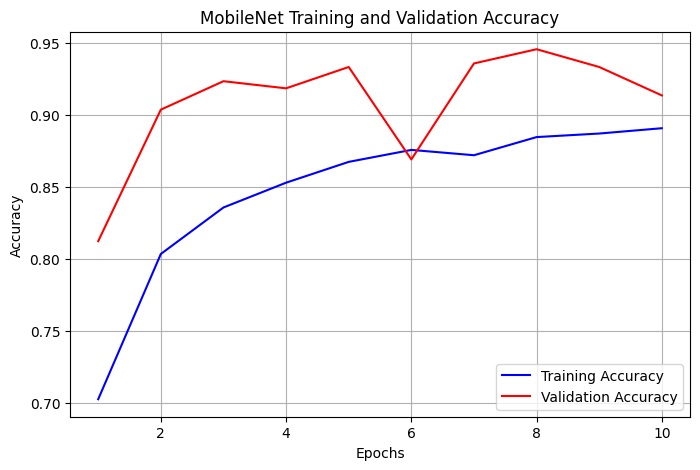

In [ ]:
# After training the model, get the accuracies from the history object
train_accuracy = mobilenet_history.history['accuracy']
val_accuracy = mobilenet_history.history['val_accuracy']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_accuracy, 'b-', label='Training Accuracy')  
plt.plot(range(len(train_accuracy)), val_accuracy, 'r-', label='Validation Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


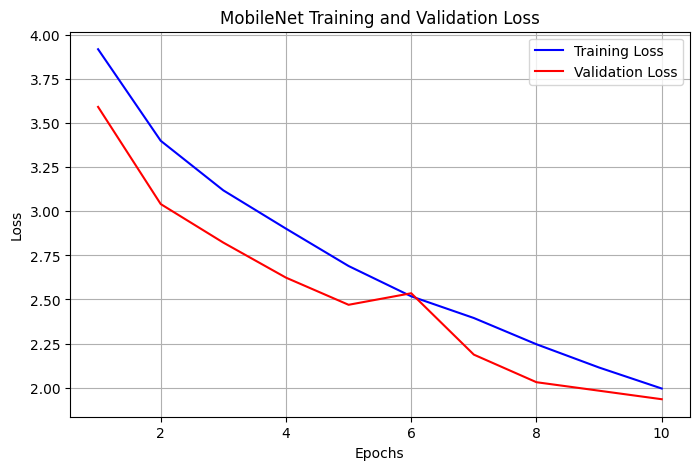

In [ ]:
# After training the model, get the losses from the history object
train_loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

# Graphic drawing
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_accuracy)), train_loss, 'b-', label='Training Loss')  
plt.plot(range(len(train_accuracy)), val_loss, 'r-', label='Validation Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNet Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 10 epoch MobileNet test block
Y_pred = mobilenet.predict(test_generator)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_generator.classes
cm = confusion_matrix(val_trues, val_preds)
report = classification_report(val_trues, val_preds, target_names=class_names)

# Print classification report for reference
print(report)
print(cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step
              precision    recall  f1-score   support

Early_Blight       0.99      0.88      0.93       162
     Healthy       0.96      0.86      0.91       102
 Late_Blight       0.82      0.99      0.90       141

    accuracy                           0.91       405
   macro avg       0.92      0.91      0.91       405
weighted avg       0.92      0.91      0.91       405

[[143   3  16]
 [  0  88  14]
 [  1   1 139]]


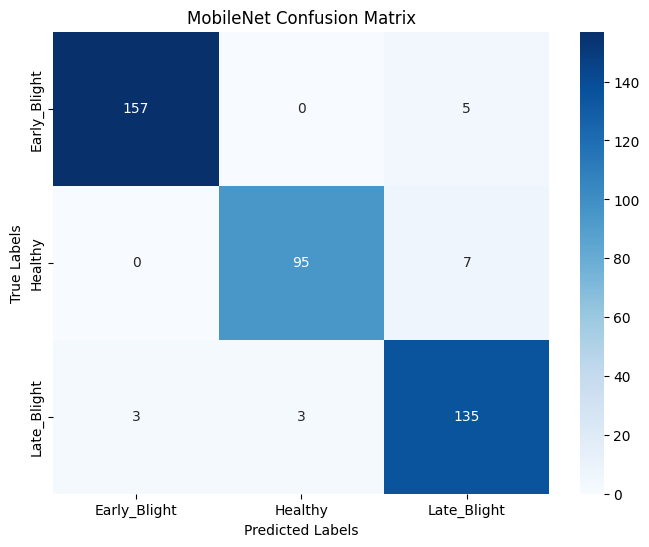

In [ ]:
# Visualize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()


# Saving the Best Performing Model

When the ResNet model was used, 97% accuracy was achieved on the test dataset. With this result, the ResNet model was selected as the model to be used in plant disease classification in the continuation of the project, as it has a higher success compared to other models.

The following code block was run to load the model back with its weights when necessary.

In [21]:
# Save the model
resnet.save('../model/resnet_potato_disease_model.h5')